In [11]:
import sys
sys.path.append('..')
from skimage import io,data
from src.model.spstfm.ksvd import KSVD
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


rng_seed = 42
torch.manual_seed(rng_seed)
torch.cuda.manual_seed(rng_seed)
# io.imshow(img)

# img_train = img[:256, :, :]
# io.imshow(img_train)
device = 'cpu'
n_components = 256
img=data.astronaut()
ksvd = KSVD(n_components=n_components,max_iter=100,tol=1e-6,sparsity=25,init_method='data_elements').to(device)
img = img.astype('float') / 255.0
img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(device)

img_norm = (img - torch.mean(img,dim=(-2,-1),keepdim=True)) / (torch.std(img,dim=(-2,-1),keepdim=True) + 1e-10)
img_patch = torch.nn.Unfold(kernel_size=8, stride=8)(img_norm)
img_patch = img_patch.reshape(3, 64, -1)
dictionary_matrix = torch.zeros(3, 64, n_components,device=device)
sparsity_matrix = torch.zeros(3, n_components, img_patch.shape[-1],device=device)
for i in range(3):
    img_patch_per_channel = img_patch[i]
    dictionary_matrix_per_channel, sparsity_matrix_per_channel = ksvd.fit(img_patch_per_channel)
    dictionary_matrix[i] = dictionary_matrix_per_channel
    sparsity_matrix[i] = sparsity_matrix_per_channel

Iteration 0, error: 0.003435, delta error: 0.003435
Iteration 1, error: 0.002130, delta error: 0.001305
Iteration 2, error: 0.001726, delta error: 0.000404
Iteration 3, error: 0.001525, delta error: 0.000200
Iteration 4, error: 0.001381, delta error: 0.000145
Iteration 5, error: 0.001316, delta error: 0.000065
Iteration 6, error: 0.001235, delta error: 0.000081
Iteration 7, error: 0.001195, delta error: 0.000040
Iteration 8, error: 0.001132, delta error: 0.000063
Iteration 9, error: 0.001085, delta error: 0.000047
Iteration 10, error: 0.001065, delta error: 0.000020
Iteration 11, error: 0.001028, delta error: 0.000037
Iteration 12, error: 0.001012, delta error: 0.000016
Iteration 13, error: 0.000985, delta error: 0.000026
Iteration 14, error: 0.000967, delta error: 0.000018
Iteration 15, error: 0.000965, delta error: 0.000002
Iteration 16, error: 0.000948, delta error: 0.000017
Iteration 17, error: 0.000919, delta error: 0.000029
Iteration 18, error: 0.000908, delta error: 0.000011
Ite

In [15]:
reconstruction = dictionary_matrix @ sparsity_matrix
reconstruction = reconstruction.reshape(1,3*64,-1)
reconstruction = torch.nn.Fold(output_size=(512, 512), kernel_size=8, stride=8)(reconstruction)
reconstruction = reconstruction.squeeze(0).permute(1, 2, 0).cpu().numpy()
img_norm = img_norm.squeeze(0).permute(1, 2, 0).cpu().numpy()

In [16]:
import numpy as np
img=data.astronaut()
img = img.astype('float') / 255.0
img_mean = np.mean(img,axis=(0,1),keepdims=True)
img_std = np.std(img,axis=(0,1),keepdims=True)
reconstruction = (reconstruction * img_std + img_mean).clip(0,1)
img_1 = img_norm*img_std + img_mean

In [13]:
reconstruction.shape

torch.Size([1, 192, 4096])

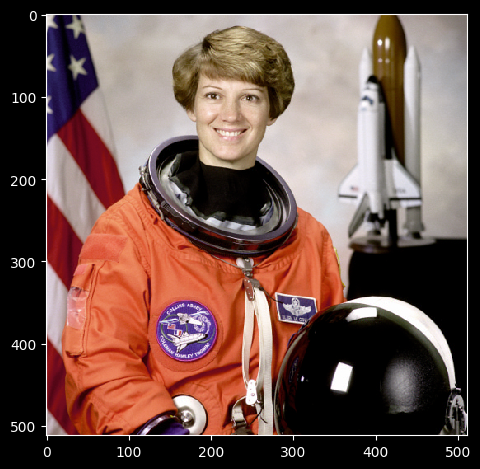

In [17]:
io.imshow(reconstruction)

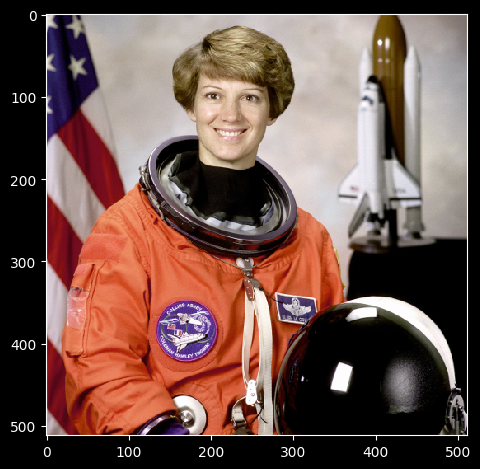

In [18]:
io.imshow(img_1)

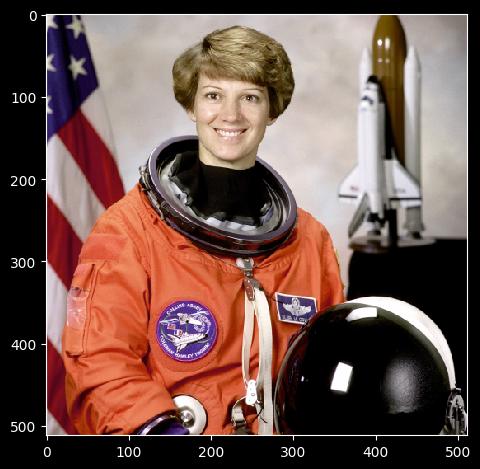

In [25]:
io.imshow(data.astronaut())